## Notebook 01: Understanding the SEVIR ML Models 

### Goal: Interogate the pre-trained ML models 

#### Background 

0. Assess the model performance.
1. Determine the important features.
2. Assess the learned relationships. 


 </div> <div class="alert alert-block alert-warning"><b>Download the Data: </b> To download the data and models, git clone https://github.com/ai2es/WAF_ML_Tutorial_Part1. If you clone the repo in ~/tai4es-trustathon-2022/severe directory then you do not need to modify the notebook </div>

In [1]:
# The WAF_ML_Tutorial repo has scripts for loading the data and additional variables 
# for plotting purposes. To take advantage those scripts, we add their path to the system path. 

import sys,os
top_path = os.path.dirname(os.getcwd())

sys.path.append(os.path.join(top_path,'WAF_ML_Tutorial_Part1/scripts/'))
sys.path.append(os.path.join(top_path,'scripts/'))
                
# These packages come from the WAF_ML_Tutorial package. 
from aux_functions import load_n_combine_df
#import some helpful descriptors 
from aux_functions import display_feature_names, color_dict, cs

# Plots ROC, performance, and reliability diagram given a model, X, and y
from verification import plot_verification

### Import the neccesary packages

In [2]:
#needed packages 
import numpy as np
import pandas as pd
import joblib
import skexplain
import shap

### Load the data. 

The data has been pre-split into training, validation, and testing datasets. 

In [3]:
# Load the data.
path_to_data=os.path.join(top_path,'WAF_ML_Tutorial_Part1/datasets/sevir/')

(X_train,y_train), (X_validate,y_validate), (X_test, y_test) = load_n_combine_df(
    path_to_data=path_to_data,features_to_keep=np.arange(0,36,1),class_labels=True)

#### Scaling the data

The ML models were trained on scaled data. We have the training data, so we can re-fit the scaler function and then scale all 3 datasets. 

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 

#create scaling object 
scaler = StandardScaler()
#fit scaler to training data
scaler.fit(X_train)

StandardScaler()

### Load the ML models. 

For this tutorial, we will load the two tree-based models (Gradient-Boosted Tree) and a logistic regression model that was trained on the SEVIR dataset. 


In [19]:
# Load the pre-trained ML models. 
basePath = os.path.join(top_path,'WAF_ML_Tutorial_Part1/datasets/sklearnmodels/classification/allfeatures')
# Format: [(model_name0, model0), (model_name1, model1), ...]
names = ['LogisticRegression', 'RandomForest', 'GradientBoostedTrees', ]
converter = {'GradientBoostedTrees' : 'GBT', 
             'LogisticRegression' : 'LR', 
             'RandomForest' : 'RF'
            }
estimators = [(converter[n.replace('.pkl', '')], joblib.load(os.path.join(basePath, f'{n}.pkl'))) for n in names]

# Make a pipeline. 
steps = [('StandardScaler', scaler)]
estimators = [(e[0], Pipeline(steps+[e])) for e in estimators]

## Step 0. Model Verification 

Before interogating an ML model, it should be worthy of interogation. In these examples, we will verify the performance of the multiple ML models. For simplicity, we will restrict our initial interogation to the best-performing model. 


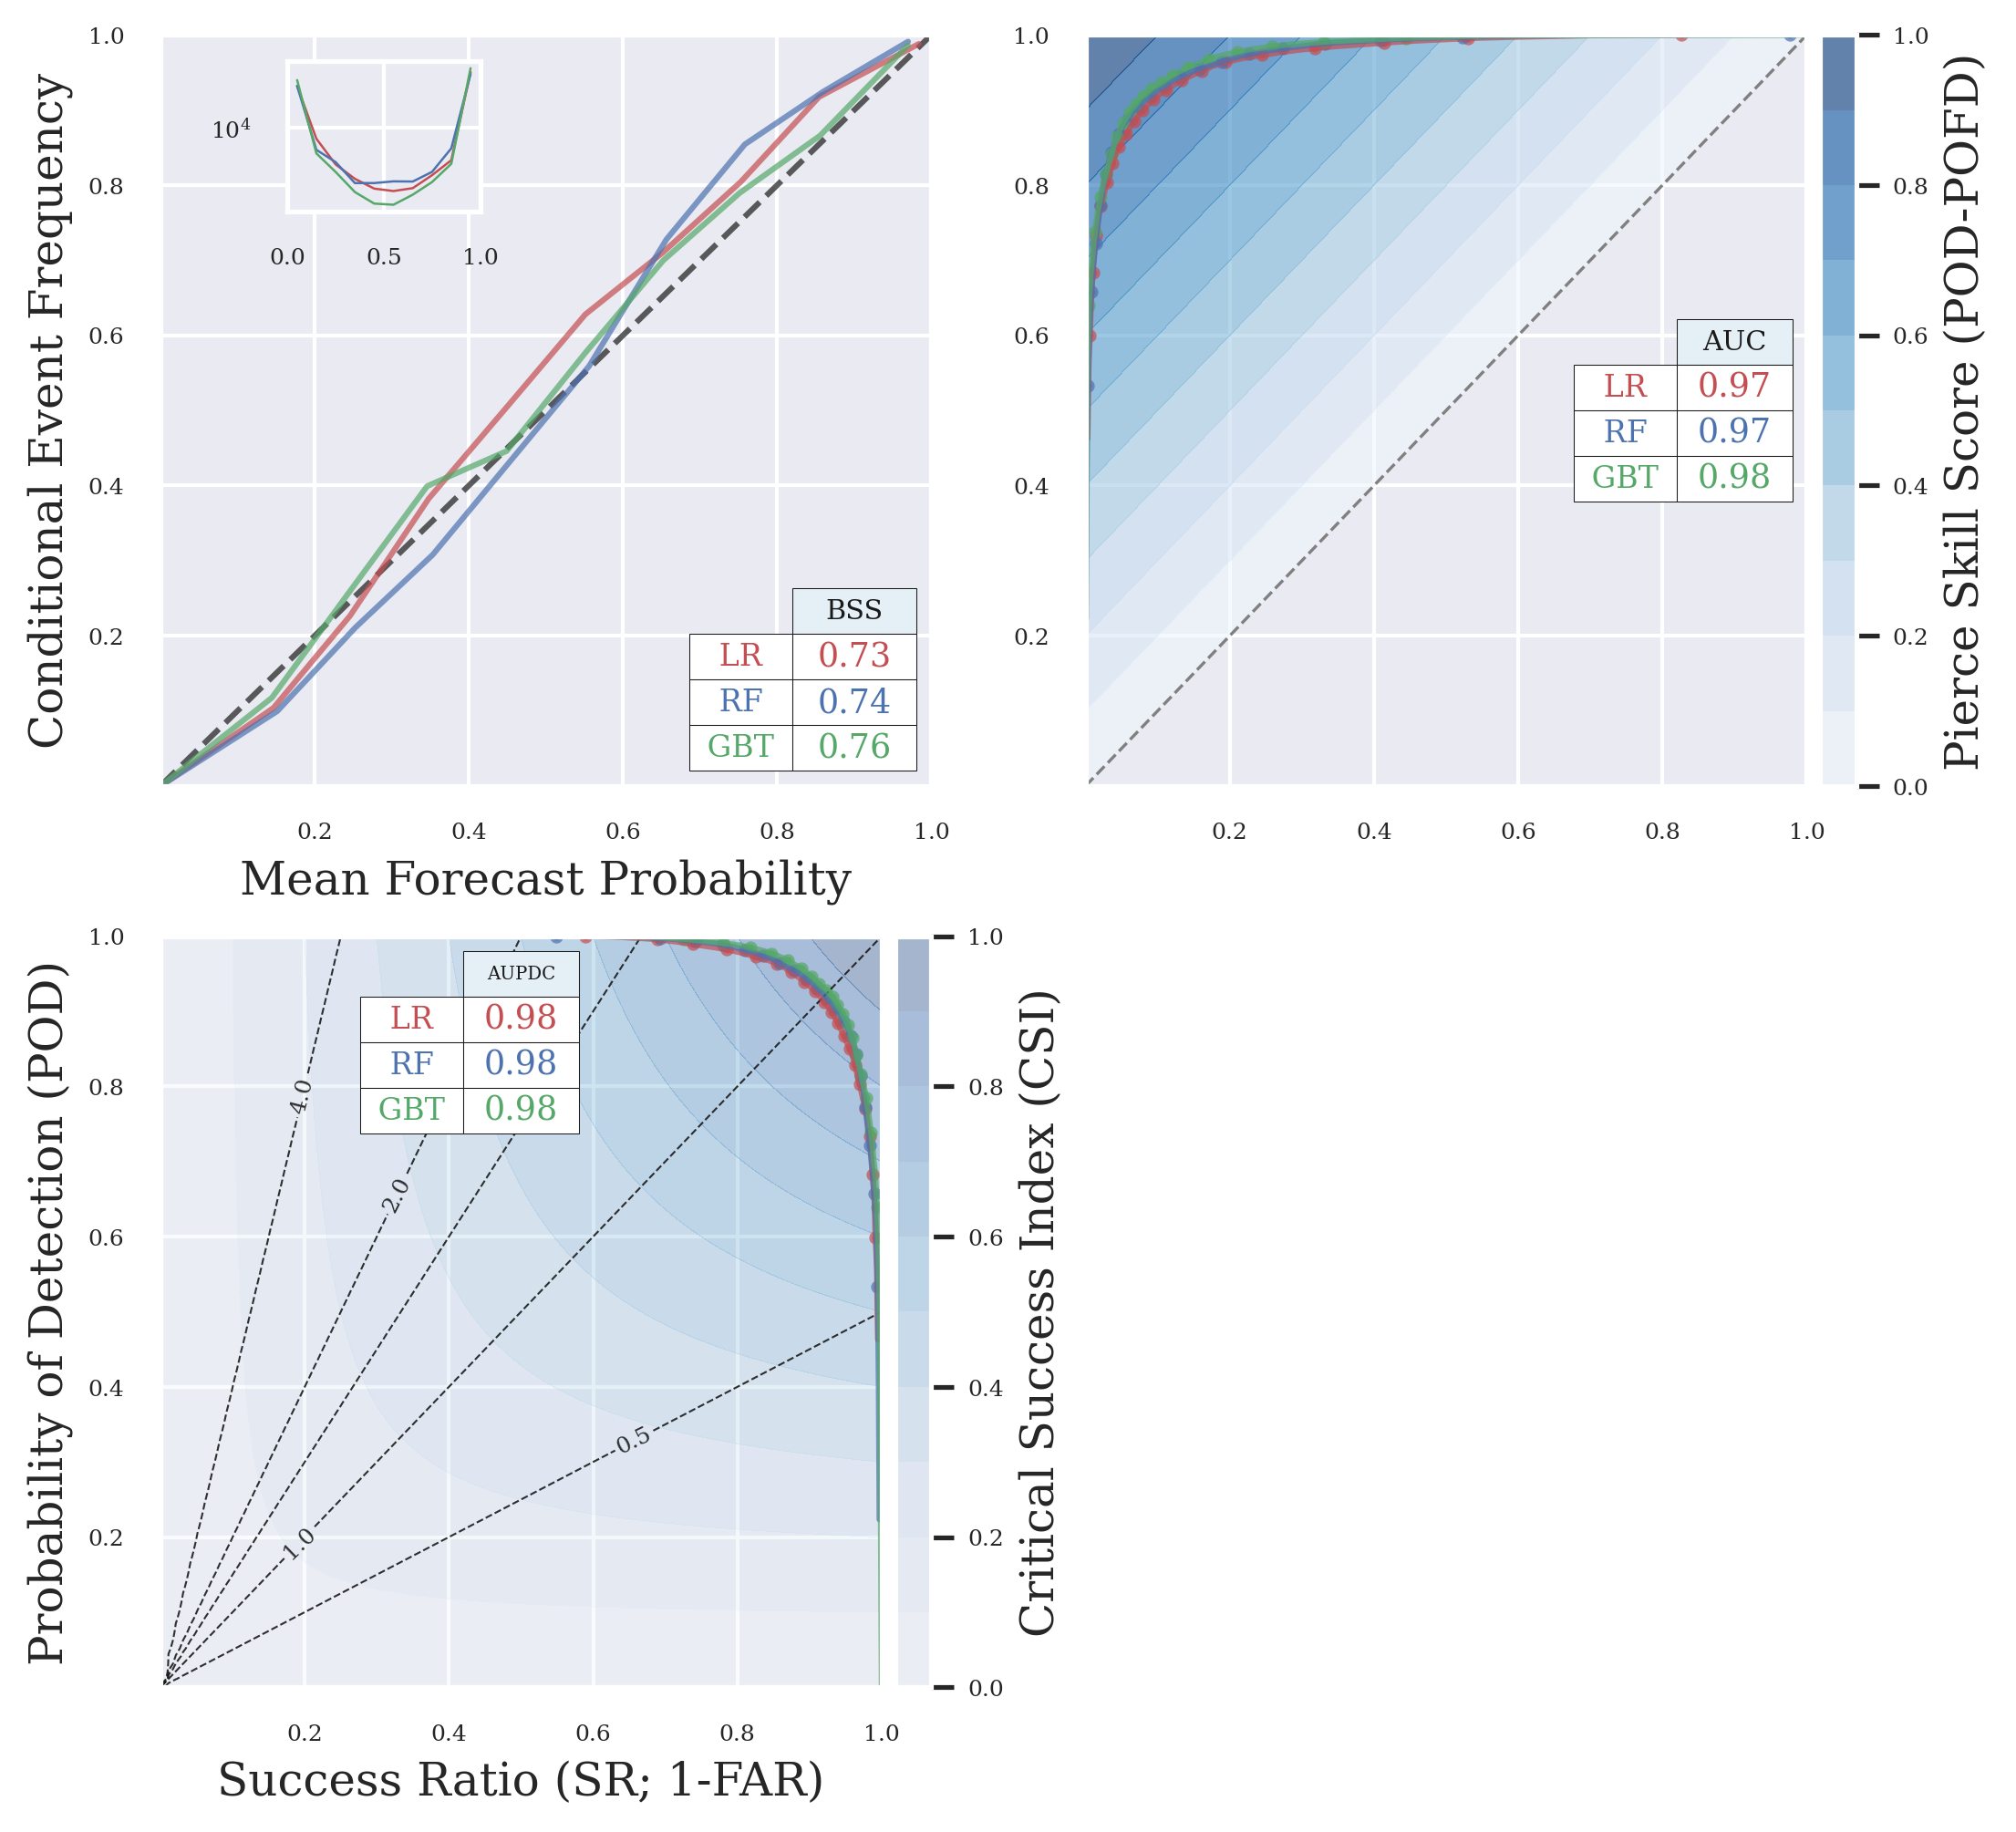

In [14]:
plot_verification(estimators, X_test, y_test)

In the above examples, we can see that all 3 models performed well. The forecasts were reliable (upper left), discriminated between events and non-events (upper right), and discriminated between false alarms and hits (lower left). Given that differences in model performances are practically insignificant, we will limit our focus to the logistic regression model. The logistic regression is a less complex, linear-based model and anticipating its future behavior will be an easier task. 


 </div> <div class="alert alert-block alert-warning"><b>Optional: </b> Repeat the following tasks, but for the random forest and gradient-boosted tree. The skill of the models are similar, but did they learn the same things? </div>


## Task 1. Analyze the Important Features 

An initial task is to blah blah blah 


In [21]:
# The logistic regression is the first model, so we can re-set estimators as the first index. 
estimators = [estimators[0]]
explainer = skexplain.ExplainToolkit(estimators, X_train, y_train, feature_names = cs)

ValueError: One or more of the estimators given has NOT been fit!

### Task 1a. (optional) Run the skexplain code yourself. 

For more information on the permutation importance in scikit-explain, check out this [tutorial] (https://github.com/monte-flora/scikit-explain/blob/master/tutorial_notebooks/permutation_importance_tutorial.ipynb). Play around with `subsample` size or the `evaluation_fn` used. Is there any sensitivity? 

In [9]:
# Comment out this command to execute the permutation importance code. 
%%script false --no-raise-error
directions = ['backward', 'forward']
evaluation_fn = ['auc', 'norm_aupdc', 'bss']
for direct in directions:
    results = explainer.permutation_importance(n_vars=5, 
                                 evaluation_fn = evaluation_fn,
                                 n_permute = 10, 
                                 subsample=0.25, 
                                 n_jobs=4, 
                                 verbose=True, 
                                 random_seed=123, 
                                 direction = direct
                                )
    explainer.save(f'perm_imp_{direct}_{evaluation_fn}.nc', results)

UsageError: Line magic function `%%script` not found.


In [15]:
# Load the data. 
results_backward = explainer.load(f'perm_imp_backward.nc')
results_forward = explainer.load(f'perm_imp_forward.nc')

### Plot the Important Features. 

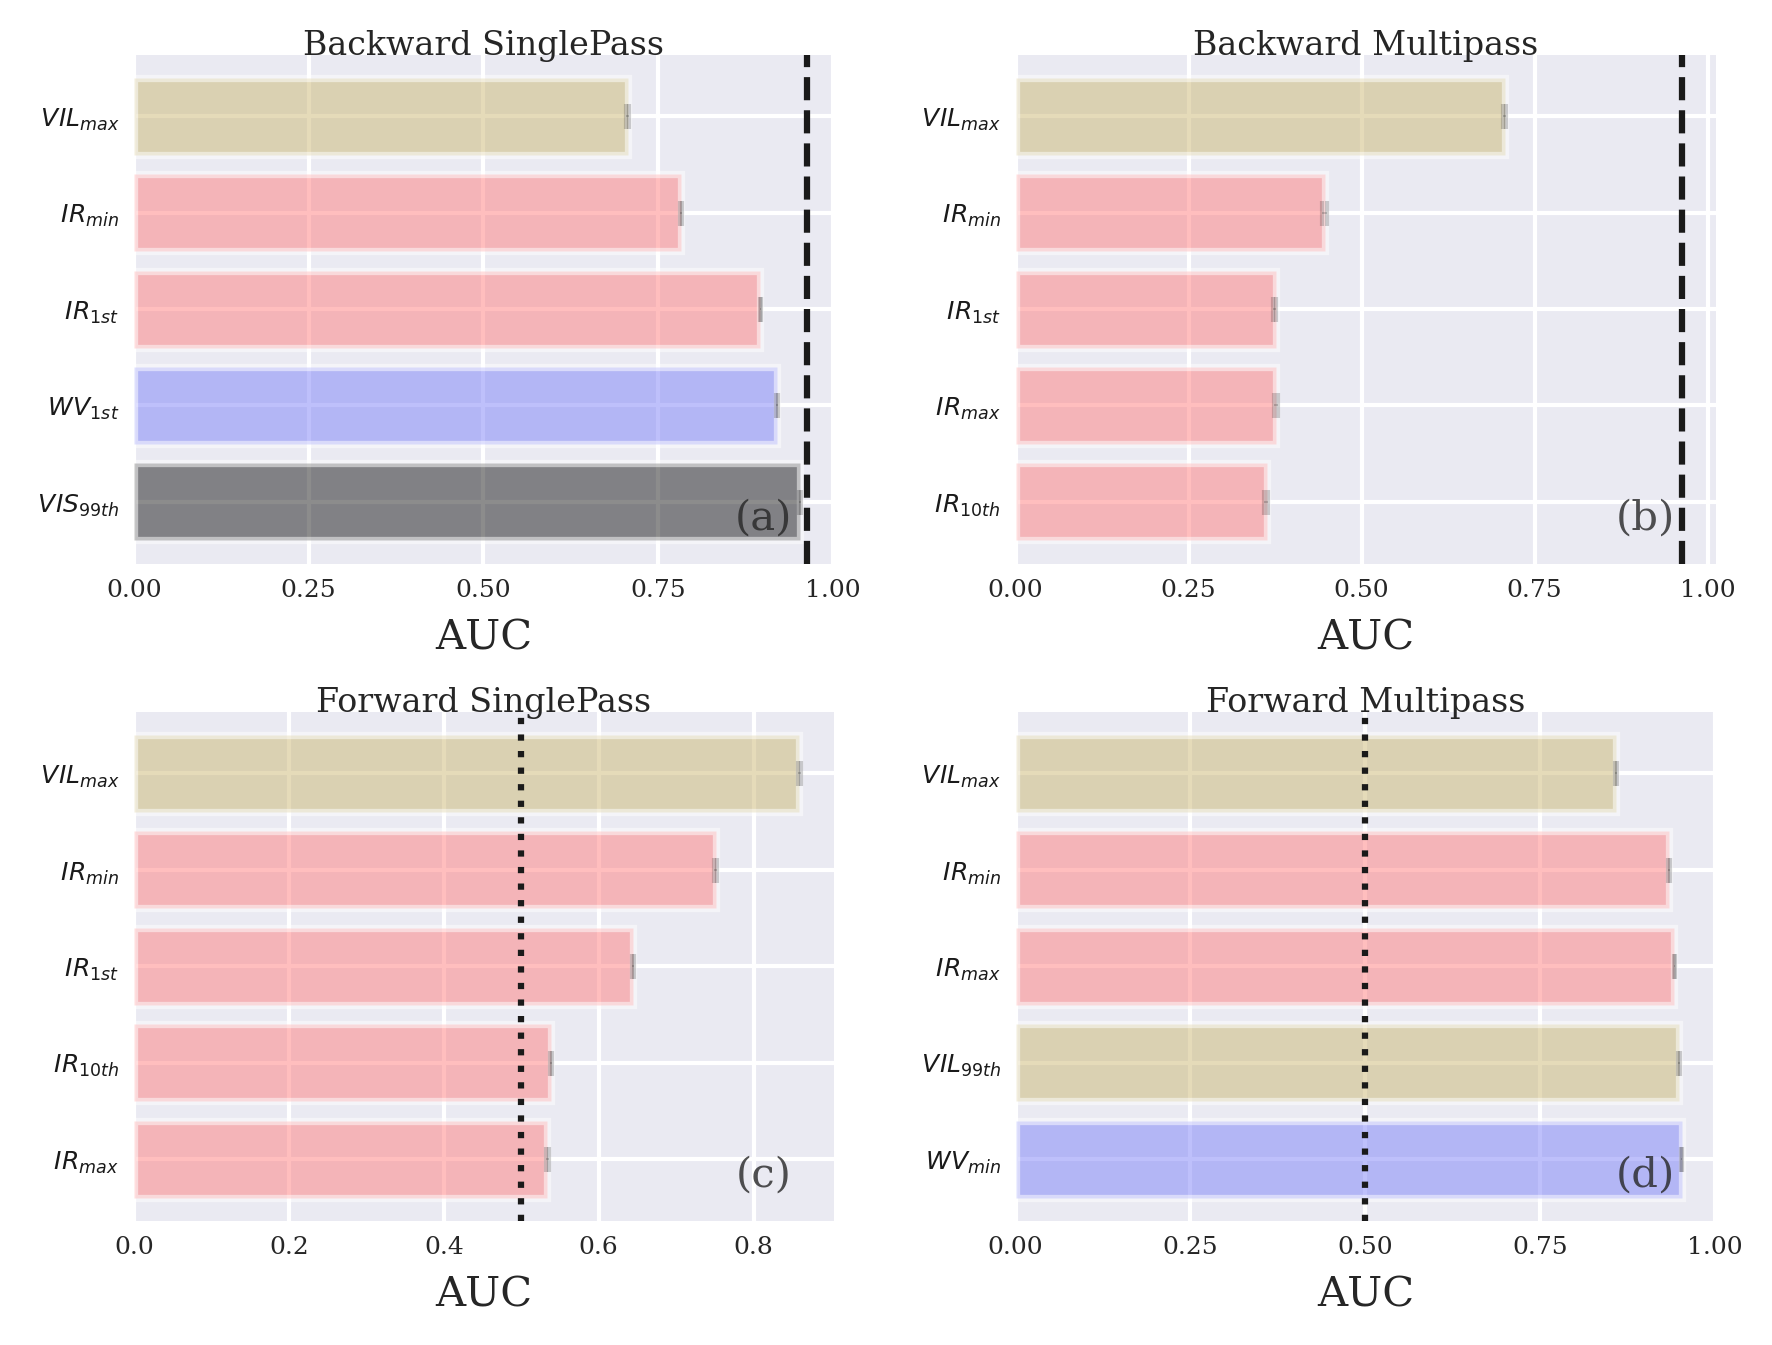

In [16]:
panels = [('singlepass', 'LR'),
          ('multipass',  'LR'),
          ('singlepass', 'LR'),
          ('multipass',  'LR'),
         ]

fig,axes = explainer.plot_importance(data=[results_backward, results_backward, 
                                           results_forward, results_forward], 
                                panels=panels,
                                num_vars_to_plot=5,
                                xlabels=['AUC']*len(panels),
                                display_feature_names=display_feature_names, 
                                feature_colors=color_dict, 
                                n_columns=2, 
                                 )

titles = ['Backward SinglePass', 'Backward Multipass', 
          'Forward SinglePass',  'Forward Multipass', 
         ]

for ax, title in zip(axes.flat, titles):
    ax.set_title(title, pad=0.02)
    if 'Forward' in title:
        ax.axvline(results_forward['all_permuted_score__LR'].mean(),color='k',ls=':')
    else:
        ax.axvline(results_forward['original_score__LR'].mean(),color='k',ls='--')

The consensus from the different permutation importance methods is that spatial-maximum VIL and the spatial-minimum infrared temperature features are the most important. This is an physically consistent result as high VIL values are associated with convective cores as are cold infrared temperatures. Let's in the next task whether these are truly the relationships learned by the logistic regression model. 

## Task 2. Analyze the Learning Relationships

In [17]:
# Get the top 2 vars. 
important_vars = explainer.get_important_vars(results_backward, n_vars=2)['LR'][:2]
# Compute the ALE 
ale_1d_ds = explainer.ale(features=important_vars, subsample=0.25,n_jobs=8, n_bins=20)

  0%|          | 0/2 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/Users/monte.flora/miniconda3/envs/ai2es/lib/python3.8/site-packages/skexplain/common/multiprocessing_utils.py", line 70, in __call__
    result = self.func(*args, **kwargs)
  File "/Users/monte.flora/miniconda3/envs/ai2es/lib/python3.8/site-packages/skexplain/main/global_explainer.py", line 775, in compute_first_order_ale
    estimator = self.estimators[estimator_name]
KeyError: 'LR'

Traceback (most recent call last):
  File "/Users/monte.flora/miniconda3/envs/ai2es/lib/python3.8/site-packages/skexplain/common/multiprocessing_utils.py", line 70, in __call__
    result = self.func(*args, **kwargs)
  File "/Users/monte.flora/miniconda3/envs/ai2es/lib/python3.8/site-packages/skexplain/main/global_explainer.py", line 775, in compute_first_order_ale
    estimator = self.estimators[estimator_name]
KeyError: 'LR'



KeyError: 'LR'

In [ ]:
explainer.plot_ale(ale_1d_ds, display_feature_names=display_feature_names, figsize=(8,4))

Success! As mentioned in the previously task, we expect higher spatial-maximum VIL values to contribute positively to the model prediction while lower spatial-minimum infrared temperatures also contribute positively. At the moment, we know that the model is skillful and has learned physically sound relationships. 

### Task 2a. (optional) Run the ALE code yourself. Also, run the PD code and plot both. 

In [ ]:
# Comment out this command to execute the permutation importance code. 
%%script false --no-raise-error

# Compute the PD
pd_1d_ds = explainer.pd(features=important_vars, subsample=0.25,n_jobs=8, n_bins=20)

## Task 3. Can we simplify the model? 

The ML models performed well on the testing datasets and the learned relationships were physically sound. Based on the permutation importance results, there was a strong consensus that spatial-maximum VIL and spatial-minimum IR were the most important features. Let's re-train the ML models on these two features and see if can maintain similar skill. If we can largely match the skill, then we have drastically improved the explainability by reducing the model to two variables.  

In [ ]:
from sklearn.linear_model import LogisticRegression

X_train = pd.DataFrame(X_train, columns=cs)
X_train_sub = X_train[important_vars]

X_test = pd.DataFrame(X_test, columns=cs)
X_test_sub = X_test[important_vars]

lr = LogisticRegression()
lr.fit(X_train_sub, y_train)

plot_verification([('LR', lr)], X_test_sub, y_test)

The predictions have become slightly underconfident for probabilities > 40% as compared to the original set of features, but the discrimination skill remains high with AUDPC of 0.97 and AUC of 0.96.

## Task 4. Explain individual predictions

In [ ]:
new_estimators = ('LR', lr)
explainer = skexplain.ExplainToolkit(estimators, X_test, y_test, feature_names = cs)

In [ ]:
results = explainer.local_contributions(method='shap', 
                                       performance_based=True,
                                       n_samples=5, 
                                       shap_kwargs={'masker' : 
                                      shap.maskers.Partition(X_train, max_samples=100, clustering="correlation"), 
                                     'algorithm' : 'auto'}
                                          )

In [ ]:
fig = explainer.plot_contributions(contrib=results,  
                            display_feature_names=display_feature_names,
                                   n_columns=2
                        )

### Task 4a (optional). Explain the 2-variable model. 

In [ ]:
new_estimators = ('LR', lr)
explainer = skexplain.ExplainToolkit(new_estimators, X_test_sub, y_test, feature_names = cs)

In [ ]:
results = explainer.local_contributions(method='shap', 
                                       performance_based=True,
                                       n_samples=5, 
                                       shap_kwargs={'masker' : 
                                      shap.maskers.Partition(X_train_sub, max_samples=100, clustering="correlation"), 
                                     'algorithm' : 'auto'}
                                          )

In [ ]:
fig = explainer.plot_contributions(contrib=results,  
                            display_feature_names=display_feature_names,
                                   n_columns=2
                        )